# A joint multilevel model for CAR 
Using MVS.CARLeroux
## Common Markov Gaussian Random Field
 $$ [P , S ] = [P | GMRF_p] [ S | GMRF_s] $$

In [1]:
## Import code:
setwd('/apps/external_plugins/biospytial_rwrapper/biospytial.rwrapper/R/')
rm(list=ls())                                                                                     
source("init_data.R")

Loading required package: MASS
Loading required package: Rcpp

Attaching package: ‘dplyr’

The following object is masked from ‘package:MASS’:

    select

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
## Extract the response variables
Y = TDF %>% select(Pinophyta,Abies)
## Extract the formula
formula_presence
rhs <- ~ Elevationm + MeanTempm
X <- model.frame(rhs,DataFrame,na.action='na.pass')

species ~ Elevationm + MeanTempm

In [3]:
K = dim(M_bis)[1]
trials <- matrix(rep(1.0,K*2), ncol=2)

In [4]:
burnin = 50000
n.sample = 100000
thin = 50
model3 <- MVS.CARleroux(cbind(Pinophyta,Abies) ~ Elevationm + MeanTempm, 
                        family = 'binomial',
                        trials=trials,
                        W=M_bis,
                        rho = 1,
                        burnin = burnin,
                        n.sample = n.sample,
                        data = DataFrame
                         )

Setting up the model.
Generating 50000 post burnin and thinned (if requested) samples.
  |======================================================================| 100%
Summarising results.
Finished in  4950.3 seconds.


In [5]:
## model
model3$modelfit

DIC           p.d          WAIC           p.w          LMPL 
    1296.0055      523.9760     1316.2689      390.8026     -860.5773 
loglikelihood 
    -124.0268

In [9]:
model3$summary.results

,Median,2.5%,97.5%,n.sample,% accept,n.effective,Geweke.diag
Pinophyta - (Intercept),-8.5480,-12.7989,-6.3994,50000,46.7,18.1,1.6
Pinophyta - Elevationm,0.0002,-0.0003,0.0007,50000,46.7,141.2,0.8
Pinophyta - MeanTempm,-0.0006,-0.0012,0.0000,50000,46.7,104.1,-5.0
Abies - (Intercept),-19.1536,-26.0860,-15.1180,50000,46.7,25.0,5.7
Abies - Elevationm,0.0010,0.0000,0.0023,50000,46.7,309.2,-1.3
Abies - MeanTempm,-0.0002,-0.0012,0.0009,50000,46.7,184.1,-3.9
Sigma11,51.0677,22.7855,100.0969,50000,100.0,3.5,-0.6
Sigma22,76.9360,46.3929,133.1596,50000,100.0,2.9,-2.0
rho,1.0000,1.0000,1.0000,NA,NA,NA,NA


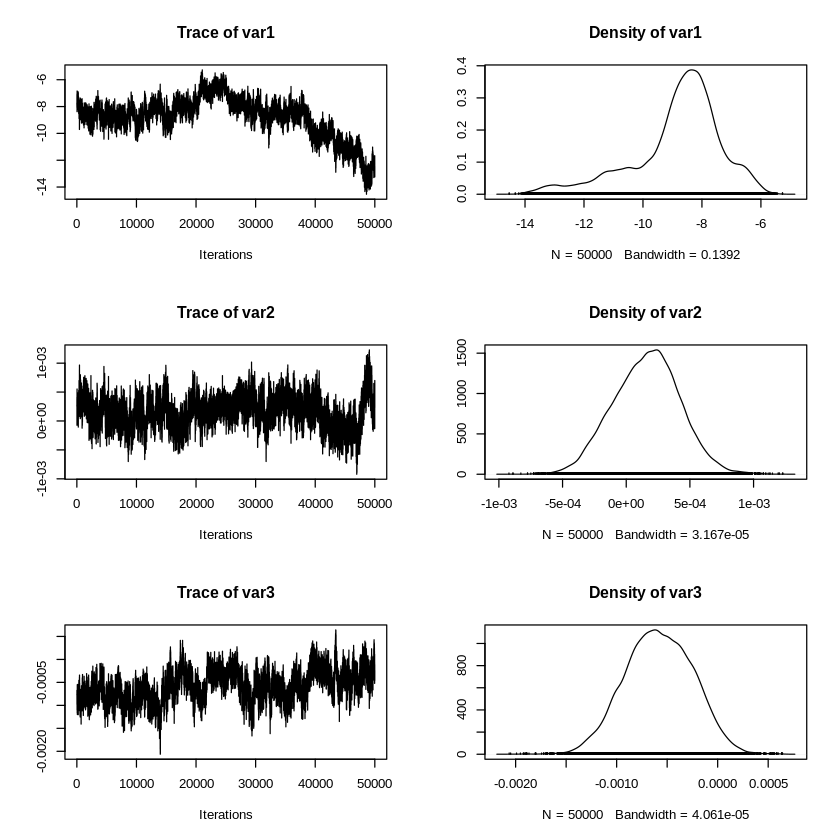

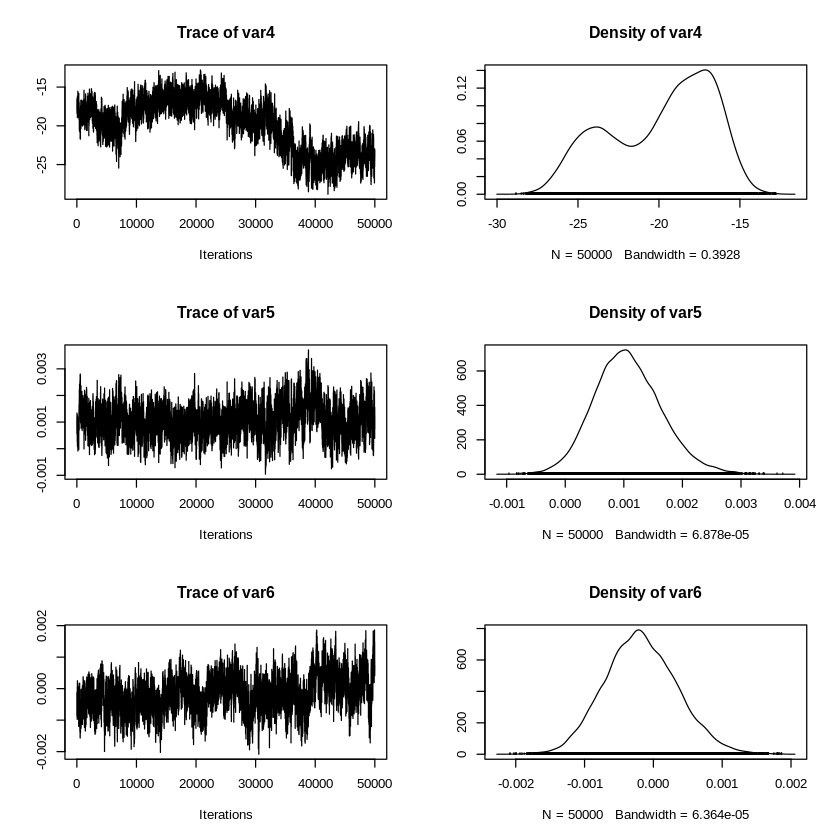

In [10]:
plot(model3$samples$beta)

## Generate datasets. several columns for summary stats

In [11]:
getUpperLowerCI <- function(fitted_sample,prefix="",MARGIN=1){
    fp = partial(quantile,probs=c(0.025,0.5,0.975))
    quants =apply(X = fitted_sample,FUN = fp,MARGIN)
    mfitt = apply(fitted_sample,mean,MARGIN = MARGIN)
    vfitt = apply(fitted_sample,var,MARGIN = MARGIN)
    new_data = cbind(t(quants),mfitt,vfitt)
    l = as.list(c("q025","median","q0975","mean","variance"))
    nnames = lapply(l,function (x){return(paste(prefix,x,sep = '_'))})
    colnames(new_data) = nnames
    return(new_data)
}

In [10]:
nK <- dim(TDF)[1]
sample_fitted <- data.frame(t(model3$samples$fitted))
sample_phi <- data.frame(t(model3$samples$phi))

In [17]:
impar = seq(from=1,to=dim(sample_fitted)[1],by=2)
par = seq(from=2,to=dim(sample_fitted)[1],by=2)

In [27]:
sS = sample_fitted[impar,]
sP = sample_fitted[par,]
S <- getUpperLowerCI(sS,prefix = 'S')
P <- getUpperLowerCI(sP,prefix = 'P')

In [32]:
sPhiS <- sample_phi[impar,]
sPhiP <- sample_phi[par,]
PhiS <- getUpperLowerCI(sPhiS,prefix='PhiS')
PhiP <- getUpperLowerCI(sPhiP,prefix='PhiP')

## Sample the posterior

In [33]:
post.sample_p = data.frame(model3$samples$fitted)
pss  <- post.sample_p %>% mutate_all(function(p) rbernoulli(1,p))
## divide samples for S and P according to the order given up
pred.S <- pss[,impar]
pred.P <- pss[,par ]
sumps <- colSums(pred.S)
sumpp <- colSums(pred.P)
nsample <- nrow(pred.S)
PX <- sumps / nsample

#nsample <- nrow(pred.P)
PY <- sumpp / nsample
PXY <- PX * PY
samples <- cbind(PX,PY,PXY)

## Save to posterity

In [34]:
data <- cbind(TDF$cellids,PhiP,PhiS,P,S,samples)

In [35]:
head(data)

,,PhiP_q025,PhiP_median,PhiP_q0975,PhiP_mean,PhiP_variance,PhiS_q025,PhiS_median,PhiS_q0975,PhiS_mean,⋯,P_mean,P_variance,S_q025,S_median,S_q0975,S_mean,S_variance,PX,PY,PXY
2,233546,-30.17501,-10.161660,8.373042,-10.157530,93.26744,-24.08795,-7.175849,5.830250,-7.752184,⋯,3.905766e-04,9.296601e-05,1.472500e-15,5.959025e-08,0.025109811,0.005290157,0.0020603111,0.01138,2e-04,2.276e-06
4,233547,-28.23960,-9.212872,7.308871,-9.397965,81.75581,-22.28487,-6.550336,5.060091,-7.130791,⋯,7.248698e-05,6.504819e-06,5.769325e-15,7.581648e-08,0.011649189,0.002947323,0.0008962812,0.00000,0e+00,0.000e+00
6,233548,-27.28896,-7.985188,7.430422,-8.494939,86.75219,-22.28355,-5.608763,5.756522,-6.466572,⋯,3.393192e-05,2.187779e-06,3.979348e-15,1.842631e-07,0.012358473,0.002121367,0.0003757533,0.00418,4e-05,1.672e-07
8,233549,-25.81719,-8.322119,7.972161,-8.487781,80.19844,-21.35034,-5.940526,5.526560,-6.468450,⋯,2.833813e-05,7.442023e-07,4.810772e-15,8.417783e-08,0.006966100,0.001970979,0.0004834536,0.00000,0e+00,0.000e+00
10,233550,-22.66249,-9.123412,7.589946,-8.564003,60.69929,-17.77697,-6.685461,5.167553,-6.509185,⋯,3.775302e-05,2.850369e-06,2.275610e-13,5.659523e-08,0.009593114,0.002062723,0.0004290445,0.00002,0e+00,0.000e+00
12,233551,-24.29869,-9.495475,6.262141,-9.147086,58.44971,-19.25678,-6.922868,4.562567,-6.976962,⋯,5.081306e-05,4.895184e-06,3.502206e-14,5.283435e-08,0.005788776,0.001669290,0.0004331693,0.00126,0e+00,0.000e+00


In [36]:
file_ = '/outputs/presence_only_models/modelCAR3.csv'
write.csv(data,file_)

## Save fitted samples (P,S)

In [106]:
sample_fitted <- t(model3$samples$fitted)
fitted_chain <- cbind(TDF$cellids,sample_fitted)
file2 <- '/outputs/presence_only_models/modelCAR_model3_fitted_sample.csv'
write.csv(fitted_chain,file2)

In [107]:
sample_phi <- t(model3$samples$phi)
nK <- dim(TDF)[1]

S <- sample_phi[1:nK,]
P <- sample_phi[(nK +1) : (2*nK), ]
chain = cbind(TDF$cellids,S)
file_ = '/outputs/presence_only_models/modelCAR_model3_phi_S.csv'
write.csv(chain,file_)
chain = cbind(TDF$cellids,P)
file_ = '/outputs/presence_only_models/modelCAR_model3_phi_P.csv'
write.csv(chain,file_)


 num [1:4060] 5.30e-05 1.89e-05 2.16e-07 2.14e-06 2.15e-06 ...


In [27]:
## P and S
## divide samples for S and P according to the order given up
nK <- dim(TDF)[1]
fittedv = model3$fitted.values
S <- fittedv[1:nK]
P <- fittedv[(nK +1) : (2*nK) ]
chain = cbind(TDF$cellids,S,P)
#file_ = '/outputs/presence_only_models/modelCAR_model3_fitted.csv'
#write.csv(chain,file_)


In [32]:
dim(model3$fitted.values)

[1] 4060    2

In [37]:
dPhi = data.frame(model3$samples$phi)

In [39]:
S <- dPhi[,1:nK]
P <- dPhi[,(nK +1) : (2*nK)]

In [56]:
mms = apply(dPhi,MARGIN=2,FUN = mean)

In [61]:
head(mms)

X1         X2         X3         X4         X5         X6 
-10.021744 -11.631782  -9.174576 -10.509941  -8.804521 -10.059669

In [57]:
ms = matrix(mms,nrow=nK,ncol=2,byrow = T)

In [62]:
head(ms)

-10.021744,-11.631782
-9.174576,-10.509941
-8.804521,-10.059669
-8.893093,-10.184749
-8.723113,-10.049559
-8.437156,-9.878672


In [58]:
fitted_chain <- cbind(TDF$cellids,ms)
file2 <- '/outputs/presence_only_models/modelCAR_model3_test.csv'
write.csv(fitted_chain,file2)


In [110]:
str(model3$samples$Sigma)

 num [1:50000, 1:2, 1:2] 60 60.8 58.7 61.4 57.5 ...


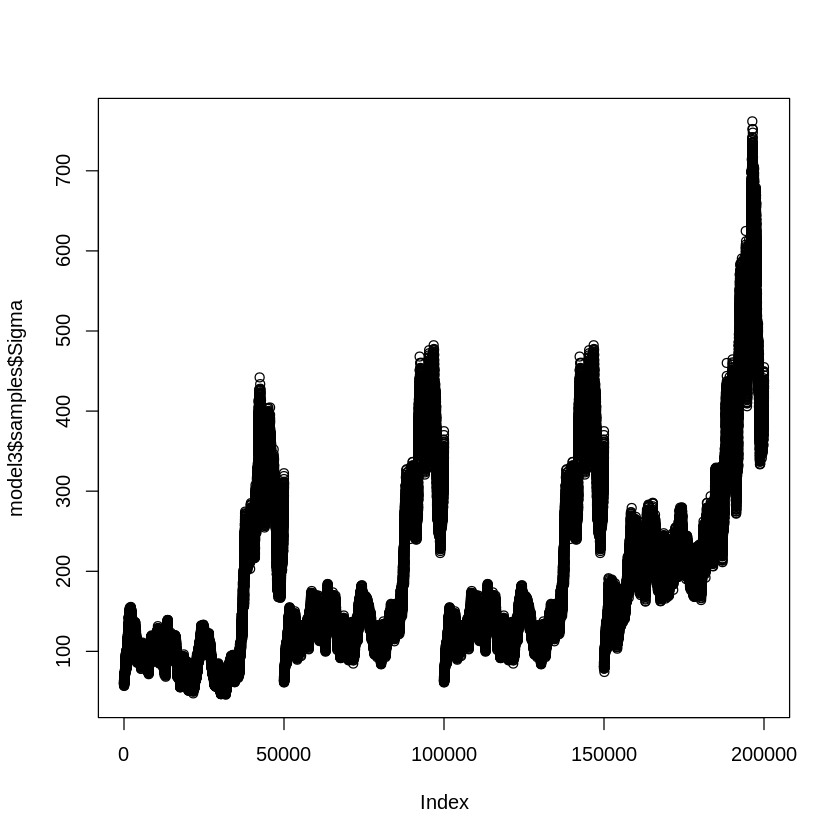

In [111]:
plot(model3$samples$Sigma)